## Outline

1. Data loading and cleaning
2. Multiclass classification
    1. Logistic regression (One-Vs-Rest Vs Multinomial)
    2. Dimensionality reduction tecniques (PCA, UMAP)
    3. Random Forest

In [3]:
# Downloading the data through Kaggle API

"""import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files('mujtabamatin/air-quality-and-pollution-assessment', path='.', unzip=True)"""

"import kaggle\nkaggle.api.authenticate()\n\nkaggle.api.dataset_download_files('mujtabamatin/air-quality-and-pollution-assessment', path='.', unzip=True)"

In [1]:
# Load the data and display the first few rows
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

data = pd.read_csv('data/air_quality/pollution.csv')
print(data.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  


In [2]:
# Display the data types of each column
print(data.info(),'\n')

print(f'Dataset shape: {data.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB
None 

Dataset shape: (5000, 10)


In [3]:
# Count the ammount of missing data
print(f'Count the number of missing data: {data.isnull().sum()}')


Count the number of missing data: Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


In [4]:
data['Air Quality'].unique()

array(['Moderate', 'Good', 'Hazardous', 'Poor'], dtype=object)

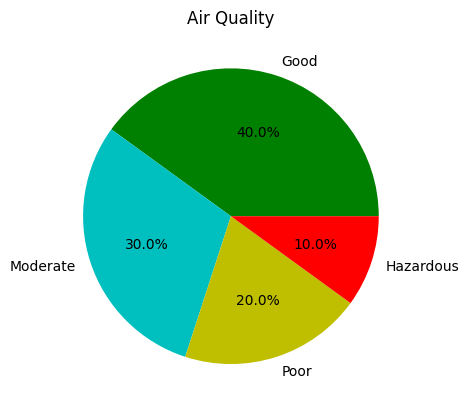

In [11]:
# Plot the occurences of the object variabel Air Quality

import matplotlib.pyplot as plt

col_lab = ['g','c','y','r']

data['Air Quality'].value_counts().plot(kind='pie', label='', autopct='%1.1f%%', colors  = col_lab)
plt.title('Air Quality')
plt.show()


In [5]:
# Change Air quality from object to numeric value

air_quality = ['Hazardous', 'Poor', 'Moderate', 'Good']

data['Air Quality'] = data['Air Quality'].replace(air_quality, [0, 1, 2, 3])
data['Air Quality'] = data['Air Quality'].astype('int')


# Display a portion of the data

print(data['Air Quality'].head())


0    2
1    2
2    2
3    3
4    3
Name: Air Quality, dtype: int64


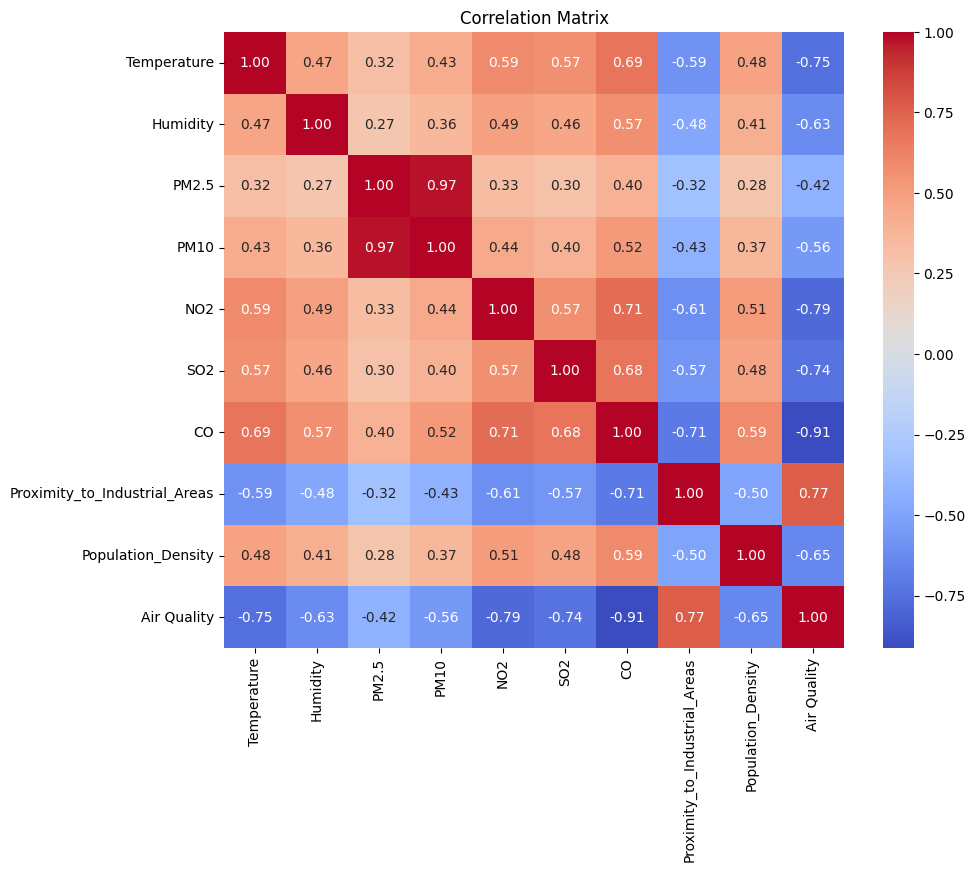

In [7]:
# Plot the correlation matrix of the data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

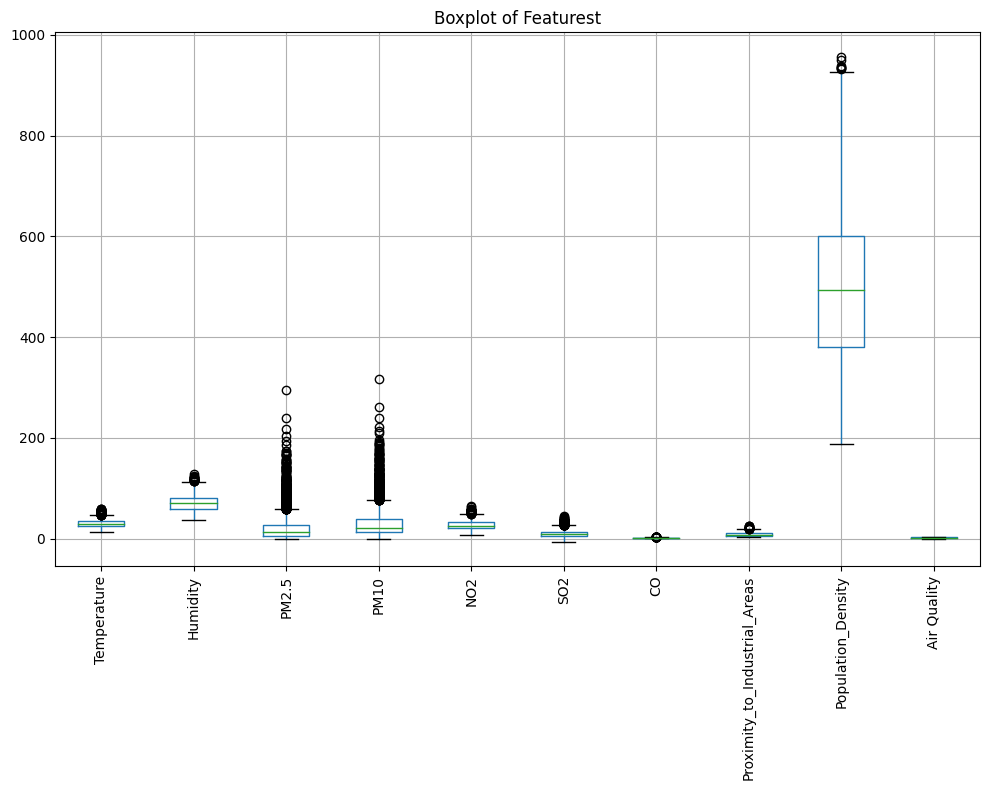

In [9]:
plt.figure(figsize=(10, 8))
data.boxplot()  
plt.title(f'Boxplot of Featurest')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [54]:
from sklearn.model_selection import train_test_split

X = data.drop('Air Quality', axis=1)
y = data['Air Quality']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=30)

print(f'Training set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')

Training set shape: (4500, 9)
Validation set shape: (500, 9)


Training set shape after SMOTE: (7196, 9)


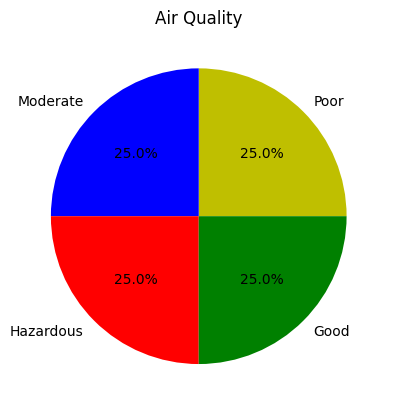

In [55]:
# Try and rebalance the data by oversampling the minority classes

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=30)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f'Training set shape after SMOTE: {X_train_sm.shape}')


lab_dict = {0: 'Hazardous', 1: 'Poor', 2: 'Moderate', 3: 'Good'}
col_lab = ['y','b', 'r', 'g']
label_mapped = y_train_sm.replace(lab_dict)
label_mapped.value_counts().plot(kind='pie', label='', autopct='%1.1f%%', colors  = col_lab)
plt.title('Air Quality')
plt.show()


In [56]:
# Standardise the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_sm = scaler.fit_transform(X_train_sm) # fit on training data and scaling themn simultaneously
X_val = scaler.transform(X_val) # only transforming the data

In [12]:
def plot_confusion_matrix(y_true, y_pred, title):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=lab_dict.values(), yticklabels=lab_dict.values())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

### Logistic Regression

In [30]:
# One Vs Rest logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


logreg_ovr = LogisticRegression(multi_class='ovr', max_iter=1000)
logreg_ovr.fit(X_train_sm, y_train_sm)

print(f'Accuracy of Logistic Regression (One Vs Rest): {accuracy_score(y_val, logreg_ovr.predict(X_val))}')

Accuracy of Logistic Regression (One Vs Rest): 0.872


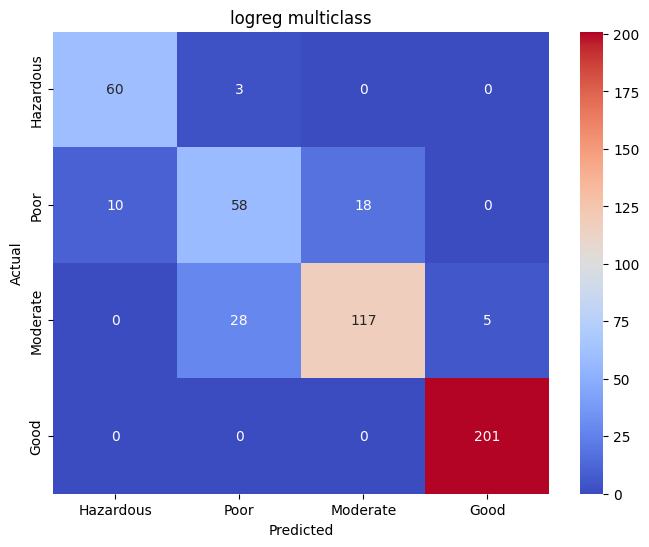

In [31]:
plot_confusion_matrix(y_val, logreg_ovr.predict(X_val), 'logreg multiclass')

In [38]:
# Improove the model

logreg_over = LogisticRegression(multi_class='ovr', max_iter=1000, class_weight='balanced', penalty='l2')
logreg_over.fit(X_train_sm, y_train_sm)

print(f'Accuracy of Logistic Regression (One Vs Rest) with class_weight: {accuracy_score(y_val, logreg_over.predict(X_val))}')

Accuracy of Logistic Regression (One Vs Rest) with class_weight: 0.898


In [41]:
print(X_train_sm.head())


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [46]:
coefficients = logreg_over.coef_
feature_names =  X_val.columns

coef_df = pd.DataFrame(coefficients, columns=feature_names)

print(coef_df)

   Temperature  Humidity     PM2.5      PM10       NO2       SO2        CO  \
0     1.182930  1.001041 -3.581134  4.097476  1.752656  0.868681  3.060940   
1    -0.062491  0.130736 -0.446617  0.464343 -0.043677  0.035607  0.201199   
2    -0.272594 -0.109445  1.374762 -1.553430 -0.377346 -0.323011 -1.053872   
3    -1.781817 -0.603511  0.587252 -1.886493 -2.005896 -2.348189 -6.990677   

   Proximity_to_Industrial_Areas  Population_Density  
0                      -0.879830            1.368812  
1                      -0.914261           -0.036729  
2                      -1.754245           -0.199093  
3                       3.213434           -0.677686  


In [50]:
# Softmax logistic regression

logreg_ovo = LogisticRegression(multi_class='multinomial', max_iter=10000)
logreg_ovo.fit(X_train_sm, y_train_sm)

print(f'Accuracy of Softmax Logistic Regression : {accuracy_score(y_val, logreg_ovo.predict(X_val))}')


Accuracy of Softmax Logistic Regression : 0.93


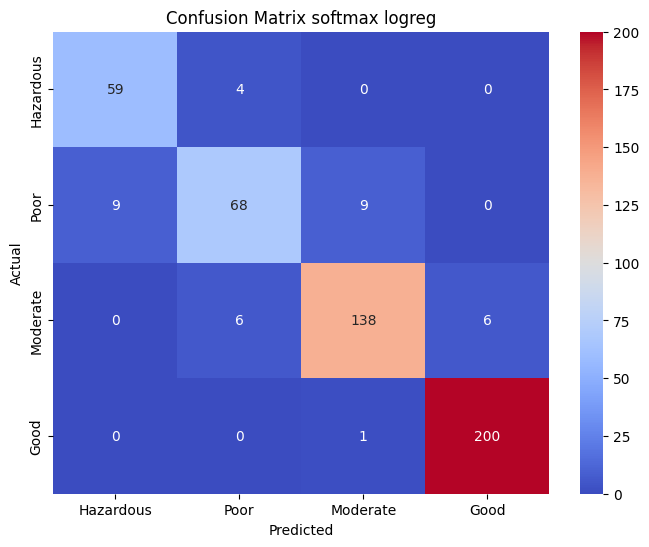

In [51]:
plot_confusion_matrix(y_val, logreg_ovo.predict(X_val), 'Confusion Matrix softmax logreg')

### Dimensionality reduction

Explained variance ratio: [0.56735906 0.15774402 0.0612671 ]


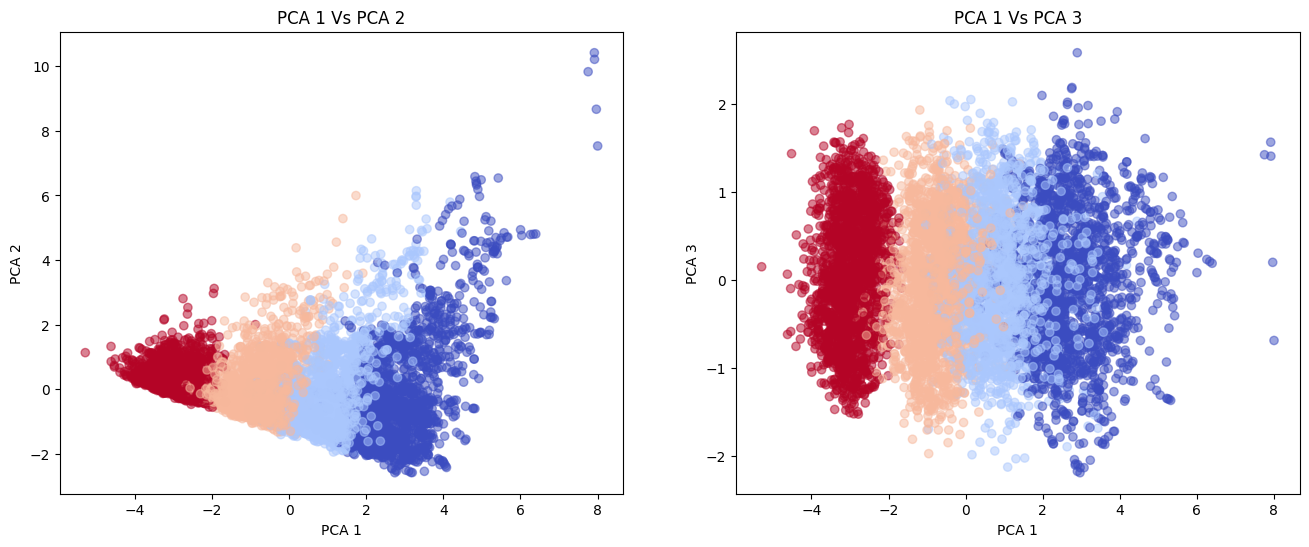

In [57]:
# Principal Component Analysis (PCA)

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_sm)
X_val_pca = pca.transform(X_val)


# Print the explained variance ratio

print(f'Explained variance ratio: {pca.explained_variance_ratio_}')

# Plot the dimensionality reduction of the data

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_sm, cmap='coolwarm', alpha=0.5)
axes[0].set_title('PCA 1 Vs PCA 2')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')

axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=y_train_sm, cmap='coolwarm', alpha=0.5)
axes[1].set_title('PCA 1 Vs PCA 3')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 3')

plt.show()

Explained variance ratio: [0.56735906]
Accuracy of Logistic Regression (One Vs Rest) with PCA: 0.888


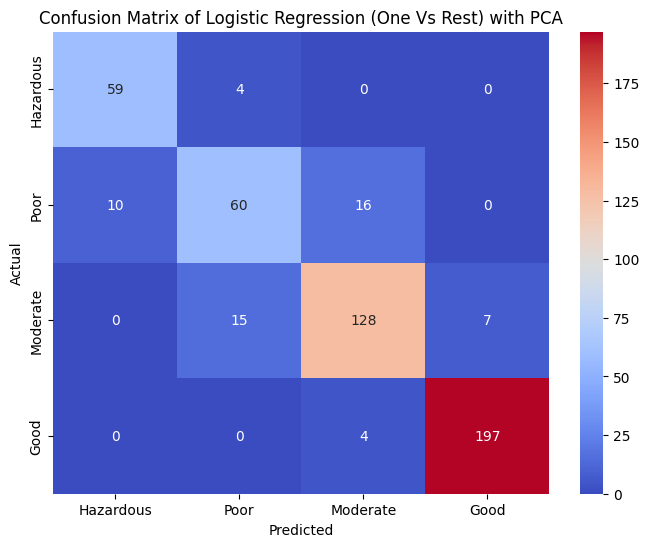

In [59]:
from sklearn.decomposition import PCA

pca_1 = PCA(n_components=1)
X_train_pca_1 = pca_1.fit_transform(X_train_sm)
X_val_pca_1 = pca_1.transform(X_val)

print(f'Explained variance ratio: {pca_1.explained_variance_ratio_}')

logreg_pca_1 = LogisticRegression(multi_class='multinomial', max_iter=10) # Same output but the model is faster, less complex, less overfitting --> less training iterations!
logreg_pca_1.fit(X_train_pca_1, y_train_sm)

print(f'Accuracy of Logistic Regression (One Vs Rest) with PCA: {accuracy_score(y_val, logreg_pca_1.predict(X_val_pca_1))}')
plot_confusion_matrix(y_val, logreg_pca_1.predict(X_val_pca_1), 'Confusion Matrix of Logistic Regression (One Vs Rest) with PCA')

Accuracy of Logistic Regression (One Vs Rest) with PCA: 0.91


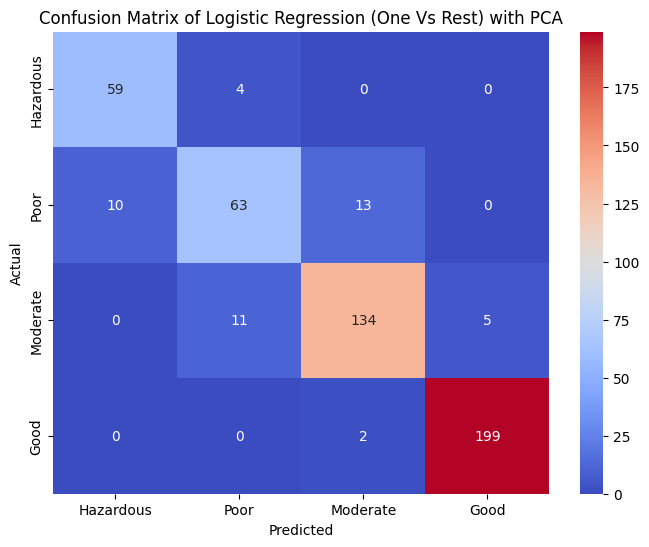

In [58]:
logreg_pca = LogisticRegression(multi_class='multinomial', max_iter=10) # Same output but the model is faster, less complex, less overfitting --> less training iterations!
logreg_pca.fit(X_train_pca, y_train_sm)

print(f'Accuracy of Logistic Regression (One Vs Rest) with PCA: {accuracy_score(y_val, logreg_pca.predict(X_val_pca))}')
plot_confusion_matrix(y_val, logreg_pca.predict(X_val_pca), 'Confusion Matrix of Logistic Regression (One Vs Rest) with PCA')

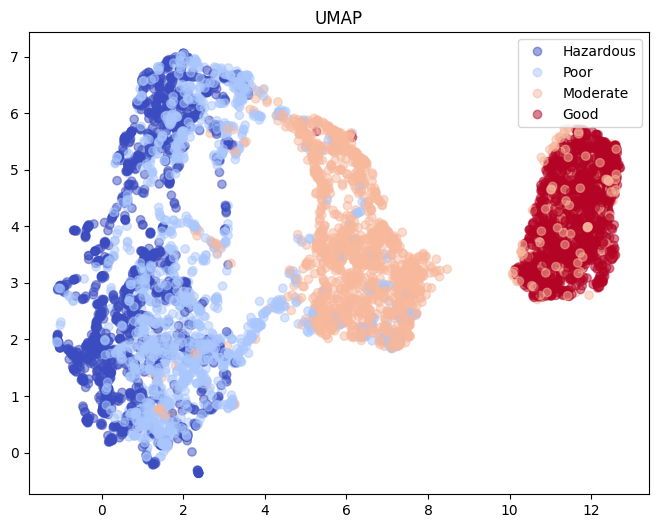

In [60]:
# Uniform Manifold Approximation and Projection for Dimensionality Reduction (UMAP)
from umap import UMAP

umap = UMAP(metric='cosine', random_state=30, n_components=3) # metrics --> manhattan, euclidean, cosine, mahalanobis, jaccard, mahalanobis

X_train_umap = umap.fit_transform(X_train_sm)
X_val_umap = umap.fit_transform(X_val)

fig = plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train_sm, cmap='coolwarm', alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=lab_dict.values())
plt.title('UMAP')
plt.show()


In [61]:
# Performing logistic regression on the UMAP data

logreg_umap = LogisticRegression(multi_class='multinomial', max_iter=10)
logreg_umap.fit(X_train_umap, y_train_sm)

print(f'Accuracy of Logistic Regression with UMAP: {accuracy_score(y_val, logreg_umap.predict(X_val_umap))}')

Accuracy of Logistic Regression with UMAP: 0.438


### One hot Encoding --> OvR

In [62]:
# Change the air quality from 0 to 3 classes to a binary one hot encoding

# Copy the data for ease of use
data_oh = data.copy()

train, val = train_test_split(data_oh, test_size=0.1, random_state=30)

X_train = train.drop('Air Quality', axis=1)
y_train = train['Air Quality']

X_val_oh = val.drop('Air Quality', axis=1)
y_val = val['Air Quality']

# Oversample the minority class
X_train_oh, y_train = smote.fit_resample(X_train, y_train)

# Create one hot encoding for the Air Quality column
y_train_oh = pd.get_dummies(y_train, prefix='Air Quality') 
y_val_oh = pd.get_dummies(y_val, prefix='Air Quality') 

# Standardise the data
X_train_oh = scaler.fit_transform(X_train_oh)
X_val_oh = scaler.transform(X_val_oh)

print(y_train_oh)

      Air Quality_0  Air Quality_1  Air Quality_2  Air Quality_3
0             False           True          False          False
1             False           True          False          False
2             False          False           True          False
3             False           True          False          False
4              True          False          False          False
...             ...            ...            ...            ...
7191          False          False           True          False
7192          False          False           True          False
7193          False          False           True          False
7194          False          False           True          False
7195          False          False           True          False

[7196 rows x 4 columns]


In [63]:
# Transform the variables from categorical to numerical

y_train_oh = y_train_oh.astype(int)

print(y_train_oh)

      Air Quality_0  Air Quality_1  Air Quality_2  Air Quality_3
0                 0              1              0              0
1                 0              1              0              0
2                 0              0              1              0
3                 0              1              0              0
4                 1              0              0              0
...             ...            ...            ...            ...
7191              0              0              1              0
7192              0              0              1              0
7193              0              0              1              0
7194              0              0              1              0
7195              0              0              1              0

[7196 rows x 4 columns]


(4, 500)
              0         1         2         3
0  3.289891e-05  0.194796  0.149615  0.011799
1  4.296955e-07  0.153207  0.332845  0.898410
2  4.529063e-08  0.176434  0.655015  0.996279
3  4.919437e-08  0.188907  0.719198  0.999211
4  7.402738e-06  0.055345  0.008474  0.221858
Accuracy of Logistic Regression Ensemble: 0.898


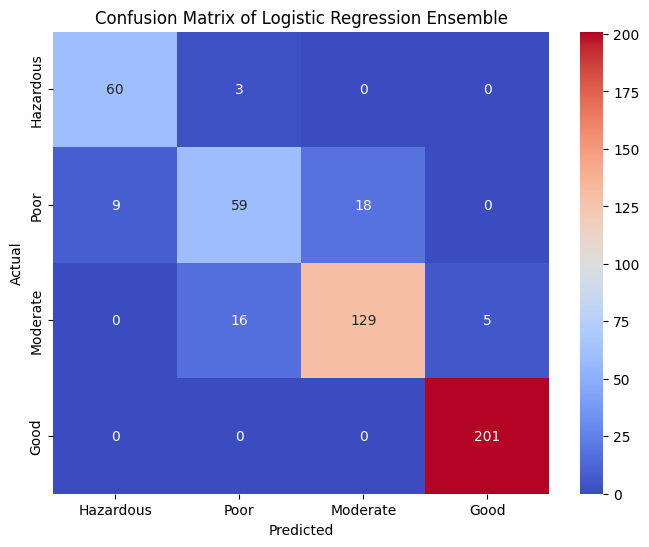

In [69]:
# Ensamble of logistic regressors models for binary classification --> OvR
import numpy as np
ens_logreg = []

for i in range(4):
    logreg = (LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2'))
    logreg.fit(X_train_oh, y_train_oh[y_train_oh.columns[i]]) 
    ens_logreg.append(logreg)

y_pred_proba = []

for i, logreg in enumerate(ens_logreg):
    y_pred_proba.append(logreg.predict_proba(X_val_oh)[:,1])

print(np.array(y_pred_proba).shape)

y_pred_proba = pd.DataFrame(y_pred_proba).T

print(y_pred_proba.head())
y_pred_final = y_pred_proba.idxmax(axis=1)



print(f'Accuracy of Logistic Regression Ensemble: {accuracy_score(y_val, y_pred_final)}')
plot_confusion_matrix(y_val, y_pred_final, 'Confusion Matrix of Logistic Regression Ensemble')


### Random Forest

In [70]:
# Normal random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=30)
rf.fit(X_train_sm, y_train_sm)

print(f'Accuracy of Random Forest: {accuracy_score(y_val, rf.predict(X_val))}')

Accuracy of Random Forest: 0.946


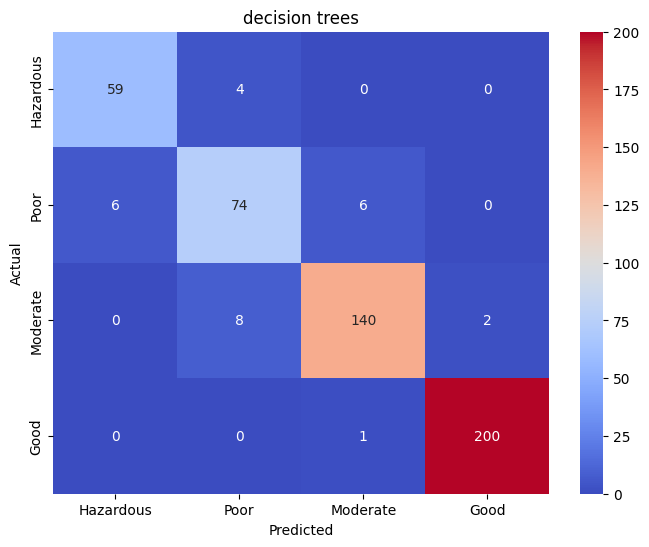

In [71]:
y_val_pred = rf.predict(X_val)

plot_confusion_matrix(y_val, y_val_pred, 'decision trees')

In [73]:
# Pruing random forest classifier

from sklearn.ensemble import GradientBoostingClassifier

rf = GradientBoostingClassifier(n_estimators=100, random_state=30, max_depth=4, min_samples_split=10)
rf.fit(X_train_sm, y_train_sm)

print(f'Accuracy of AdaBoost Random Forest: {accuracy_score(y_val, rf.predict(X_val))}')

Accuracy of AdaBoost Random Forest: 0.94
